In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Base Drive folder
BASE_DRIVE_PATH = "/content/drive/MyDrive/stock_prediction/"

DATA_DRIVE_PATH = BASE_DRIVE_PATH + "data/"
PRED_DRIVE_PATH = BASE_DRIVE_PATH + "prediction/"
MODEL_DRIVE_PATH = BASE_DRIVE_PATH + "saved_models/"

import os
os.makedirs(DATA_DRIVE_PATH, exist_ok=True)
os.makedirs(PRED_DRIVE_PATH, exist_ok=True)
os.makedirs(MODEL_DRIVE_PATH, exist_ok=True)


Mounted at /content/drive


In [ ]:

# ------------------------------------------------------------------------------

# Colab-ready: NSE Stock Price Prediction Pipeline (Multi-Seed Version)
# Runs 10 seeds, averages results, tracks best seed, and creates comparison plots

# Usage (Colab):
# 1) Paste this cell, run it.
# 2) After setup finishes run:
#    all_results, best_seed_info = train_nse_multiseed("reliance", window=20, batch=32, epochs=30, n_seeds=10)
#    plot_comparison(all_results, best_seed_info, stock="reliance")
# ------------------------------------------------------------------------------

# Install dependencies (Colab)
# !pip install -q yfinance pandas matplotlib tensorflow

# ------------------------------------------------------------------------------

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------
# Utilities & metrics
# ----------------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ----------------------------
# Filenames
# ----------------------------
def candidate_paths(stock):
    s = stock.lower()
    base = f"{DATA_DRIVE_PATH}{s}"
    old_price = f"{base}/data_harga_{s}.csv"
    new_price = f"{base}/price_data_{s}.csv"
    return dict(price_old=old_price, price_new=new_price, base=base)

# ----------------------------
# Price fetcher (yfinance) for NSE tickers
# ----------------------------
def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS",
        "tcs": "TCS.NS",
        "infosys": "INFY.NS",
        "hdfc": "HDFCBANK.NS",
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")
    if end is None:
        end = datetime.today().strftime("%Y-%m-%d")
    print(f"Fetching {ticker} from yfinance {start} → {end}")
    t = yf.Ticker(ticker)
    try:
        history = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print(f"yfinance fetch error: {e}")
        history = pd.DataFrame()
    if history.empty:
        return history
    history = history.reset_index().rename(columns={"Date": "Date"})
    return history

# ----------------------------
# Safe loader
# ----------------------------
def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)

    try:
        ensure_dir(cp['base'])
    except Exception as e:
        print(f"Error creating directory: {e}")
        raise

    try:
        if os.path.exists(cp['price_old']):
            price = pd.read_csv(cp['price_old'])
            print(f"Loaded price from {cp['price_old']}")
        elif os.path.exists(cp['price_new']):
            price = pd.read_csv(cp['price_new'])
            print(f"Loaded price from {cp['price_new']}")
        else:
            price = fetch_price_yf(stock, start="2014-01-01")
            if price.empty:
                print("[WARNING] yfinance failed — creating placeholder price data")
                idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
                base_price = 100
                changes = np.random.randn(len(idx)) * 2
                close_prices = base_price + np.cumsum(changes)
                close_prices = np.clip(close_prices, 10, None)

                price = pd.DataFrame({
                    'Date': idx,
                    'Open': close_prices * (1 + np.random.uniform(-0.02, 0.02, len(idx))),
                    'High': close_prices * (1 + np.random.uniform(0, 0.03, len(idx))),
                    'Low': close_prices * (1 - np.random.uniform(0, 0.03, len(idx))),
                    'Close': close_prices,
                    'Volume': np.random.randint(1000000, 10000000, size=len(idx))
                })
                price['High'] = price[['Open', 'High', 'Close']].max(axis=1)
                price['Low'] = price[['Open', 'Low', 'Close']].min(axis=1)

            price.to_csv(cp['price_new'], index=False)
            print(f"Saved price to {cp['price_new']}")
    except Exception as e:
        print(f"Error loading/saving price data: {e}")
        raise

    return price

# ----------------------------
# Data preprocessing
# ----------------------------
def preprocess_price_data(df):
    columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
    available_cols = [col for col in columns_to_keep if col in df.columns]

    if not available_cols:
        raise ValueError("No usable price columns found in dataframe")

    clean_df = df[available_cols].copy()
    all_nan_cols = clean_df.columns[clean_df.isna().all()].tolist()
    if all_nan_cols:
        raise ValueError(f"Columns with all NaN values found: {all_nan_cols}")

    clean_df = clean_df.ffill().bfill()
    initial_rows = len(clean_df)
    clean_df = clean_df.dropna()
    dropped_rows = initial_rows - len(clean_df)
    if dropped_rows > 0:
        print(f"Warning: Dropped {dropped_rows} rows with NaN values")

    if len(clean_df) == 0:
        raise ValueError("No valid data remaining after NaN removal")

    if 'Volume' in clean_df.columns:
        clean_df['Volume'] = clean_df['Volume'].abs()
        clean_df.loc[clean_df['Volume'] == 0, 'Volume'] = 1

    price_cols = [c for c in ['Open', 'High', 'Low', 'Close'] if c in clean_df.columns]
    for col in price_cols:
        if (clean_df[col] <= 0).any():
            print(f"Warning: Non-positive values found in {col}, clipping to minimum of 0.01")
            clean_df[col] = clean_df[col].clip(lower=0.01)

    return clean_df.reset_index(drop=True)

# ----------------------------
# Windowing
# ----------------------------
def make_windows(df, window_size, target_col='Close'):
    arr = df.copy()
    if target_col not in arr.columns:
        target_col = arr.columns[0]
    cols = [target_col] + [c for c in arr.columns if c != target_col]
    arr = arr[cols]
    data = arr.values

    if len(data) <= window_size:
        raise ValueError(f"Not enough data. Need at least {window_size + 1} records, got {len(data)}")

    n_samples = len(data) - window_size
    X = np.zeros((n_samples, window_size, arr.shape[1]), dtype=np.float32)
    y = np.zeros((n_samples, 1), dtype=np.float32)

    for i in range(n_samples):
        X[i] = data[i:i+window_size]
        y[i, 0] = data[i+window_size, 0]

    return X, y


In [ ]:
def make_tf_dataset(X, y, batch=32, shuffle=True, seed=8):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(1000, len(X)), seed=seed)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Positional encoding layer
# ----------------------------
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super().__init__(**kwargs)

        self.seq_len = seq_len
        self.d_model = d_model

        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        input_features = tf.shape(x)[-1]
        return x + self.pe[:, :tf.shape(x)[1], :input_features]

# ----------------------------
# TCN block
# ----------------------------
def tcn_block(x, filters, kernel_size=3, dilation_rate=1, dropout=0.1, final=False, seed=8):
    y = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    y = LayerNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(dropout, seed=seed)(y)
    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final:
        out = GlobalAveragePooling1D()(out)
    return out

# ----------------------------
# Model builders
# ----------------------------
def build_bilstm(input_shape, seed=8):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True, seed=seed))(x)
    x = Dropout(0.2, seed=seed)(x)
    x = Bidirectional(LSTM(64, return_sequences=False, seed=seed))(x)
    x = Dropout(0.2, seed=seed)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

def build_tcn(input_shape, seed=8):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = tcn_block(x, filters=64, kernel_size=5, dilation_rate=1, dropout=0.2, final=False, seed=seed)
    x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=2, dropout=0.2, final=False, seed=seed)
    x = tcn_block(x, filters=32, kernel_size=3, dilation_rate=4, dropout=0.2, final=True, seed=seed)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

def build_tcn_bilstm(input_shape, seed=8):
    seq_len, d_model = input_shape
    inp = Input(shape=input_shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)

    t = tcn_block(x, filters=32, kernel_size=5, dilation_rate=1, dropout=0.2, final=False, seed=seed)
    t = tcn_block(t, filters=32, kernel_size=3, dilation_rate=2, dropout=0.2, final=True, seed=seed)

    b = Bidirectional(LSTM(64, return_sequences=False, seed=seed))(x)
    b = Dropout(0.2, seed=seed)(b)

    c = Concatenate()([t, b])
    c = Dense(32, activation='relu')(c)
    out = Dense(1)(c)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae', 'mse', rmse, calc_r2_score])
    return model

# ----------------------------
# Training function for single seed
# ----------------------------
def train_single_seed(stock, seed, window=20, batch=32, epochs=200, X_train_scaled=None, y_train_scaled=None,
                      X_val_scaled=None, y_val_scaled=None, X_test_scaled=None, y_test_scaled=None,
                      target_scaler=None, shape=None, verbose=0):

    np.random.seed(seed)
    tf.random.set_seed(seed)

    train_ds = make_tf_dataset(X_train_scaled, y_train_scaled, batch=batch, shuffle=True, seed=seed)
    val_ds = make_tf_dataset(X_val_scaled, y_val_scaled, batch=batch, shuffle=False, seed=seed)

    models = {}
    results = {}

    # BiLSTM
    m_bilstm = build_bilstm(shape, seed=seed)
    m_bilstm.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose,
                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)])
    models['bilstm'] = m_bilstm

    # TCN
    m_tcn = build_tcn(shape, seed=seed)
    m_tcn.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
                         tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)])
    models['tcn'] = m_tcn

    # TCN-BiLSTM
    m_tcnb = build_tcn_bilstm(shape, seed=seed)
    m_tcnb.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=70, restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30)])
    models['tcn_bilstm'] = m_tcnb

    # Evaluate
    for model_name, model in models.items():
        y_pred_scaled = model.predict(X_test_scaled, verbose=0)
        y_true_unscaled = target_scaler.inverse_transform(y_test_scaled).flatten()
        y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled).flatten()

        mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
        mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
        rmse_val = math.sqrt(mse)
        r2 = r2_score(y_true_unscaled, y_pred_unscaled)

        mask = y_true_unscaled != 0
        mape = np.mean(np.abs((y_true_unscaled[mask] - y_pred_unscaled[mask]) /
                              y_true_unscaled[mask])) * 100 if mask.sum() > 0 else float('inf')

        results[model_name] = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse_val,
            'r2': r2,
            'mape': mape,
            'y_true': y_true_unscaled,
            'y_pred': y_pred_unscaled
        }

    return models, results

# ----------------------------
# Multi-seed training
# ----------------------------
def train_nse_multiseed(stock, window=20, batch=32, epochs=200, n_seeds=10, save_best=True):

    stock = stock.lower()
    print("\n" + "="*60)
    print(f"Training models for {stock.upper()} with {n_seeds} seeds")
    print("="*60 + "\n")

    price_df = safe_load_price(stock)
    clean_df = preprocess_price_data(price_df)

    ensure_dir(f"{DATA_DRIVE_PATH}{stock}")
    ensure_dir(f"{PRED_DRIVE_PATH}{stock}")
    ensure_dir(f"{MODEL_DRIVE_PATH}{stock}")

    X, y = make_windows(clean_df, window)

    n = len(X)
    i1, i2 = int(0.7*n), int(0.85*n)

    X_train, y_train = X[:i1], y[:i1]
    X_val, y_val = X[i1:i2], y[i1:i2]
    X_test, y_test = X[i2:], y[i2:]

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    ts, ws, fs = X_train.shape
    Xtr2d = X_train.reshape(-1, fs)
    feature_scaler.fit(Xtr2d)
    target_scaler.fit(y_train)

    X_train_scaled = feature_scaler.transform(Xtr2d).reshape(ts, ws, fs)
    y_train_scaled = target_scaler.transform(y_train)

    vs = X_val.shape[0]
    Xv2 = X_val.reshape(-1, fs)
    X_val_scaled = feature_scaler.transform(Xv2).reshape(vs, ws, fs)
    y_val_scaled = target_scaler.transform(y_val)

    ts2 = X_test.shape[0]
    Xt2 = X_test.reshape(-1, fs)
    X_test_scaled = feature_scaler.transform(Xt2).reshape(ts2, ws, fs)
    y_test_scaled = target_scaler.transform(y_test)

    shape = (window, X.shape[2])

    all_seed_results = {'bilstm': [], 'tcn': [], 'tcn_bilstm': []}

    best_seed = None
    best_models = None
    best_results = None
    best_rmse = float('inf')

    for i, seed in enumerate(range(n_seeds)):
        print("\n" + "-"*60)
        print(f"Training seed {i+1}/{n_seeds} (seed={seed})")
        print("-"*60)

        models, results = train_single_seed(stock, seed, window, batch, epochs,
                                            X_train_scaled, y_train_scaled,
                                            X_val_scaled, y_val_scaled,
                                            X_test_scaled, y_test_scaled,
                                            target_scaler, shape, verbose=0)

        for m in ['bilstm', 'tcn', 'tcn_bilstm']:
            all_seed_results[m].append(results[m])

        avg_rmse = np.mean([results[m]['rmse'] for m in ['bilstm','tcn','tcn_bilstm']])
        print(f"Seed {seed} - Average RMSE: {avg_rmse:.2f}")

        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_seed = seed
            best_models = models
            best_results = results

    print("\n" + "="*60)
    print("Averaged Results Across All Seeds")
    print("="*60 + "\n")

    averaged_results = {}
    for m in ['bilstm','tcn','tcn_bilstm']:
        arr = all_seed_results[m]
        preds = np.array([r['y_pred'] for r in arr])
        avg_pred = preds.mean(axis=0)
        std_pred = preds.std(axis=0)
        y_true = arr[0]['y_true']

        mae = mean_absolute_error(y_true, avg_pred)
        mse = mean_squared_error(y_true, avg_pred)
        rmse_val = math.sqrt(mse)
        r2 = r2_score(y_true, avg_pred)
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - avg_pred[mask]) / y_true[mask])) * 100 if mask.sum()>0 else float('inf')

        averaged_results[m] = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse_val,
            'r2': r2,
            'mape': mape,
            'y_true': y_true,
            'y_pred': avg_pred,
            'y_pred_std': std_pred
        }

        print(f"{m.upper()}:")
        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse_val:.2f}")
        print(f"  R²:   {r2:.4f}")
        if mape != float('inf'): print(f"  MAPE: {mape:.2f}%")
        print()

        df = pd.DataFrame({
            'y_true': y_true,
            'y_pred_avg': avg_pred,
            'y_pred_std': std_pred,
            'error': y_true - avg_pred
        })
        df.to_csv(f"{PRED_DRIVE_PATH}{stock}/{m}_predictions_avg.csv", index=False)

    print("\n" + "="*60)
    print(f"Best Seed: {best_seed} (Average RMSE: {best_rmse:.2f})")
    print("="*60 + "\n")

    for m in ['bilstm','tcn','tcn_bilstm']:
        r = best_results[m]
        print(f"{m.upper()} (Best Seed):")
        print(f"  MAE:  {r['mae']:.2f}")
        print(f"  RMSE: {r['rmse']:.2f}")
        print(f"  R²:   {r['r2']:.4f}")
        if r['mape'] != float('inf'): print(f"  MAPE: {r['mape']:.2f}%")
        print()

        df = pd.DataFrame({
            'y_true': r['y_true'],
            'y_pred': r['y_pred'],
            'error': r['y_true'] - r['y_pred']
        })
        df.to_csv(f"{PRED_DRIVE_PATH}{stock}/{m}predictions_best_seed{best_seed}.csv", index=False)

        if save_best:
            model_dir = f"{MODEL_DRIVE_PATH}{stock}/{m}best_seed{best_seed}"
            ensure_dir(model_dir)
            best_models[m].save(f"{model_dir}/model.keras")

    return averaged_results, {'seed': best_seed, 'results': best_results, 'models': best_models}

# ----------------------------
# Comparison plotting
# ----------------------------
def plot_comparison(averaged_results, best_seed_info, stock):

    y_true = averaged_results['bilstm']['y_true']

    fig = plt.figure(figsize=(18,12))

    ax1 = plt.subplot(3,2,1)
    ax1.plot(y_true, label='True Value', linewidth=2, alpha=0.8, color='black')
    ax1.plot(averaged_results['bilstm']['y_pred'], label='BiLSTM (Avg)')
    ax1.plot(averaged_results['tcn']['y_pred'], label='TCN (Avg)')
    ax1.plot(averaged_results['tcn_bilstm']['y_pred'], label='TCN-BiLSTM (Avg)')
    ax1.set_title(f"{stock.upper()} - Averaged Predictions Across Seeds")
    ax1.legend(); ax1.grid(True,alpha=0.3)

    ax2 = plt.subplot(3,2,2)
    br = best_seed_info['results']
    ax2.plot(y_true, label='True Value', linewidth=2, alpha=0.8, color='black')
    ax2.plot(br['bilstm']['y_pred'], label='BiLSTM')
    ax2.plot(br['tcn']['y_pred'], label='TCN')
    ax2.plot(br['tcn_bilstm']['y_pred'], label='TCN-BiLSTM')
    ax2.set_title(f"{stock.upper()} - Best Seed {best_seed_info['seed']}")
    ax2.legend(); ax2.grid(True,alpha=0.3)

    minv, maxv = y_true.min(), y_true.max()

    ax3 = plt.subplot(3,2,3)
    ax3.scatter(y_true, averaged_results['bilstm']['y_pred'], alpha=0.5)
    ax3.scatter(y_true, averaged_results['tcn']['y_pred'], alpha=0.5)
    ax3.scatter(y_true, averaged_results['tcn_bilstm']['y_pred'], alpha=0.5)
    ax3.plot([minv,maxv],[minv,maxv],'r--')
    ax3.set_title("Actual vs Predicted - Averaged")
    ax3.grid(True,alpha=0.3)

    ax4 = plt.subplot(3,2,4)
    ax4.scatter(y_true, br['bilstm']['y_pred'], alpha=0.5)
    ax4.scatter(y_true, br['tcn']['y_pred'], alpha=0.5)
    ax4.scatter(y_true, br['tcn_bilstm']['y_pred'], alpha=0.5)
    ax4.plot([minv,maxv],[minv,maxv],'r--')
    ax4.set_title(f"Actual vs Predicted - Best Seed {best_seed_info['seed']}")
    ax4.grid(True,alpha=0.3)

    ax5 = plt.subplot(3,2,5)
    models = ['BiLSTM','TCN','TCN-BiLSTM']

    rmse_avg = [averaged_results['bilstm']['rmse'],
                averaged_results['tcn']['rmse'],
                averaged_results['tcn_bilstm']['rmse']]

    rmse_best = [br['bilstm']['rmse'],
                 br['tcn']['rmse'],
                 br['tcn_bilstm']['rmse']]

    x = np.arange(len(models))
    w = 0.35
    ax5.bar(x-w/2, rmse_avg, w)
    ax5.bar(x+w/2, rmse_best, w)
    ax5.set_xticks(x); ax5.set_xticklabels(models)
    ax5.set_title("RMSE Comparison"); ax5.grid(True,alpha=0.3)

    ax6 = plt.subplot(3,2,6)
    r2_avg = [averaged_results['bilstm']['r2'],
              averaged_results['tcn']['r2'],
              averaged_results['tcn_bilstm']['r2']]

    r2_best = [br['bilstm']['r2'],
               br['tcn']['r2'],
               br['tcn_bilstm']['r2']]

    ax6.bar(x-w/2, r2_avg, w)
    ax6.bar(x+w/2, r2_best, w)
    ax6.set_xticks(x); ax6.set_xticklabels(models)
    ax6.set_title("R² Comparison"); ax6.grid(True,alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{PRED_DRIVE_PATH}{stock}/comparison_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

    # detailed uncertainty
    fig2,axes = plt.subplots(3,1,figsize=(16,12))

    for idx,(m,label) in enumerate([('bilstm','BiLSTM'),
                                    ('tcn','TCN'),
                                    ('tcn_bilstm','TCN-BiLSTM')]):
        ax = axes[idx]

        avg = averaged_results[m]['y_pred']
        std = averaged_results[m]['y_pred_std']

        ax.plot(y_true, label='True', linewidth=2, color='black')
        ax.plot(avg, label=f"{label} (Avg)")
        ax.fill_between(range(len(avg)), avg-std, avg+std, alpha=0.3)

        ax.plot(br[m]['y_pred'], label=f"{label} (Best Seed {best_seed_info['seed']})", linestyle='--')

        ax.set_title(f"{stock.upper()} - {label} Predictions with Uncertainty")
        ax.grid(True,alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.savefig(f"{PRED_DRIVE_PATH}{stock}/detailed_comparison_with_uncertainty.png",
                dpi=300, bbox_inches='tight')
    plt.show()



Training models for RELIANCE with 10 seeds

Loaded price from /content/drive/MyDrive/stock_prediction/data/reliance/price_data_reliance.csv

------------------------------------------------------------
Training seed 1/10 (seed=0)
------------------------------------------------------------
Seed 0 - Average RMSE: 35.48

------------------------------------------------------------
Training seed 2/10 (seed=1)
------------------------------------------------------------
Seed 1 - Average RMSE: 33.71

------------------------------------------------------------
Training seed 3/10 (seed=2)
------------------------------------------------------------
Seed 2 - Average RMSE: 36.95

------------------------------------------------------------
Training seed 4/10 (seed=3)
------------------------------------------------------------
Seed 3 - Average RMSE: 36.16

------------------------------------------------------------
Training seed 5/10 (seed=4)
-------------------------------------------------

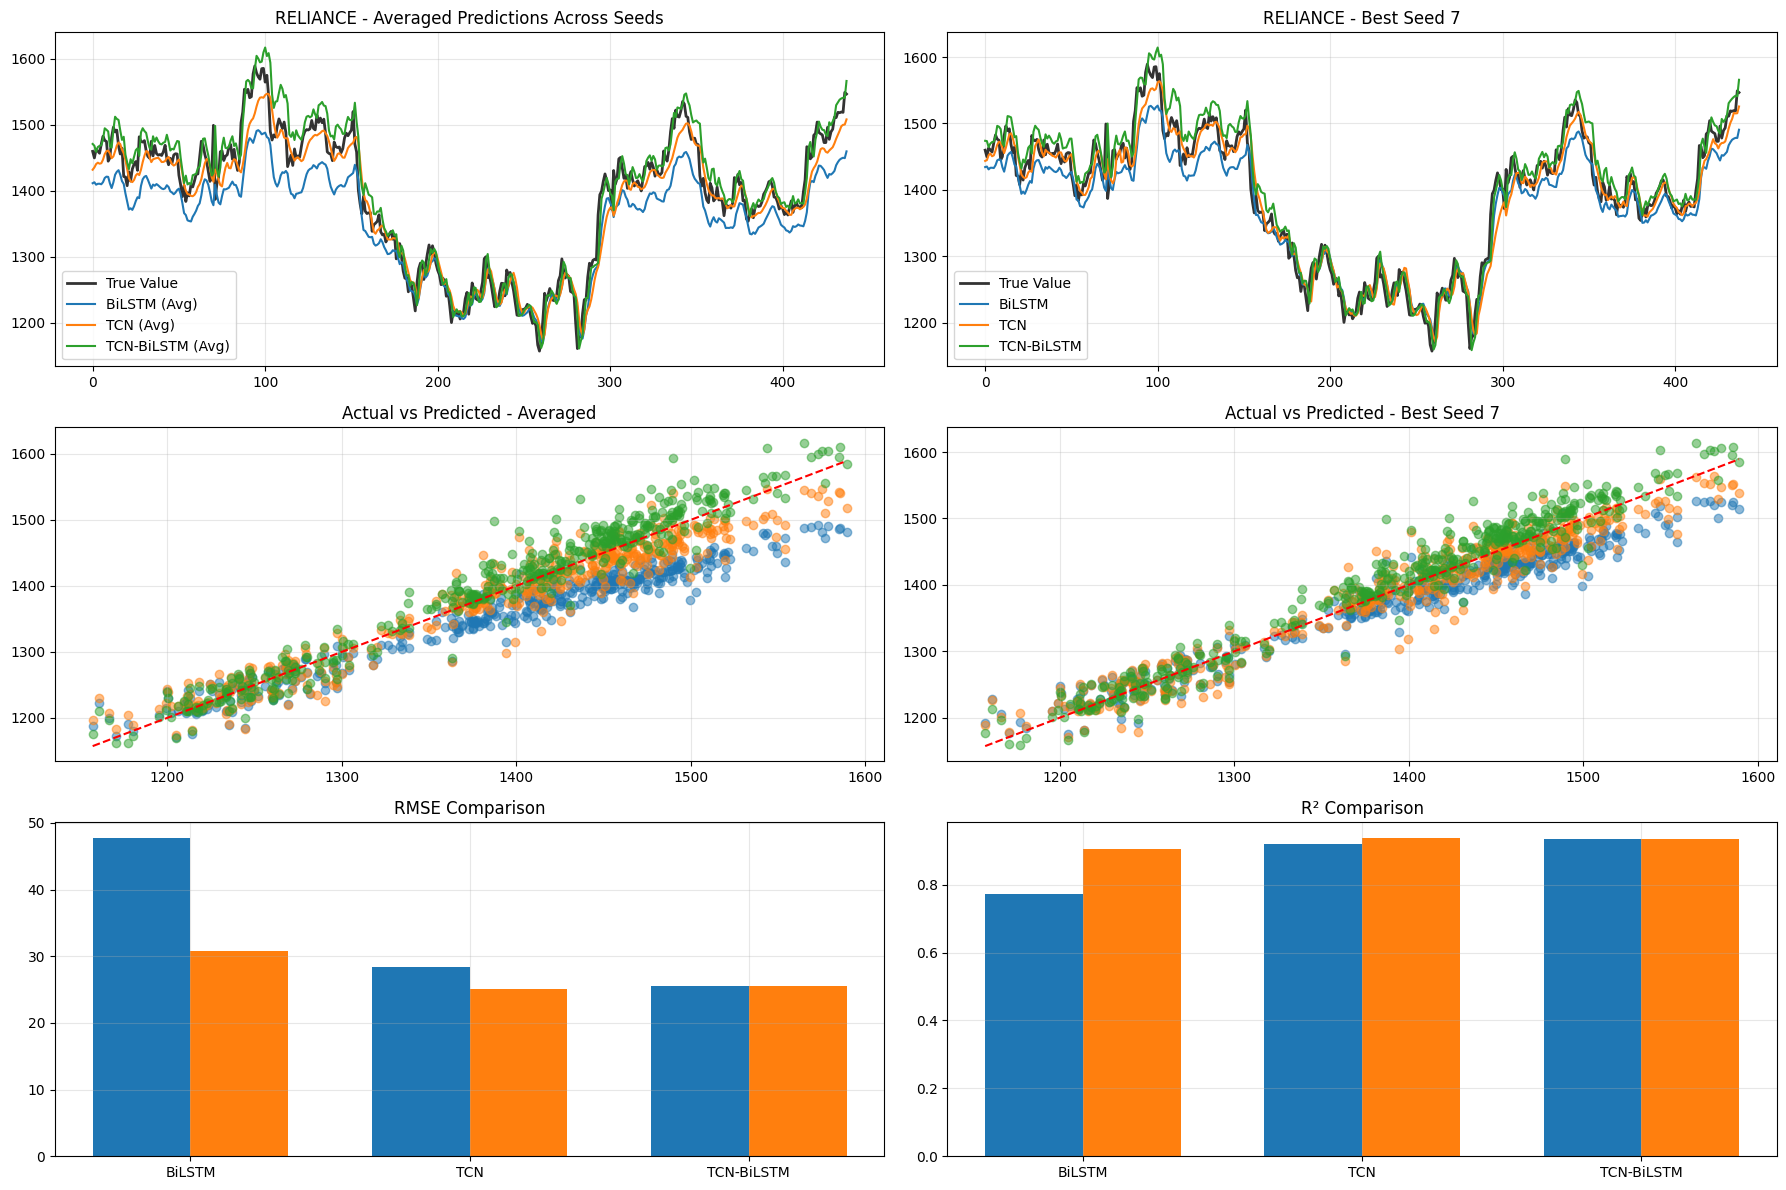

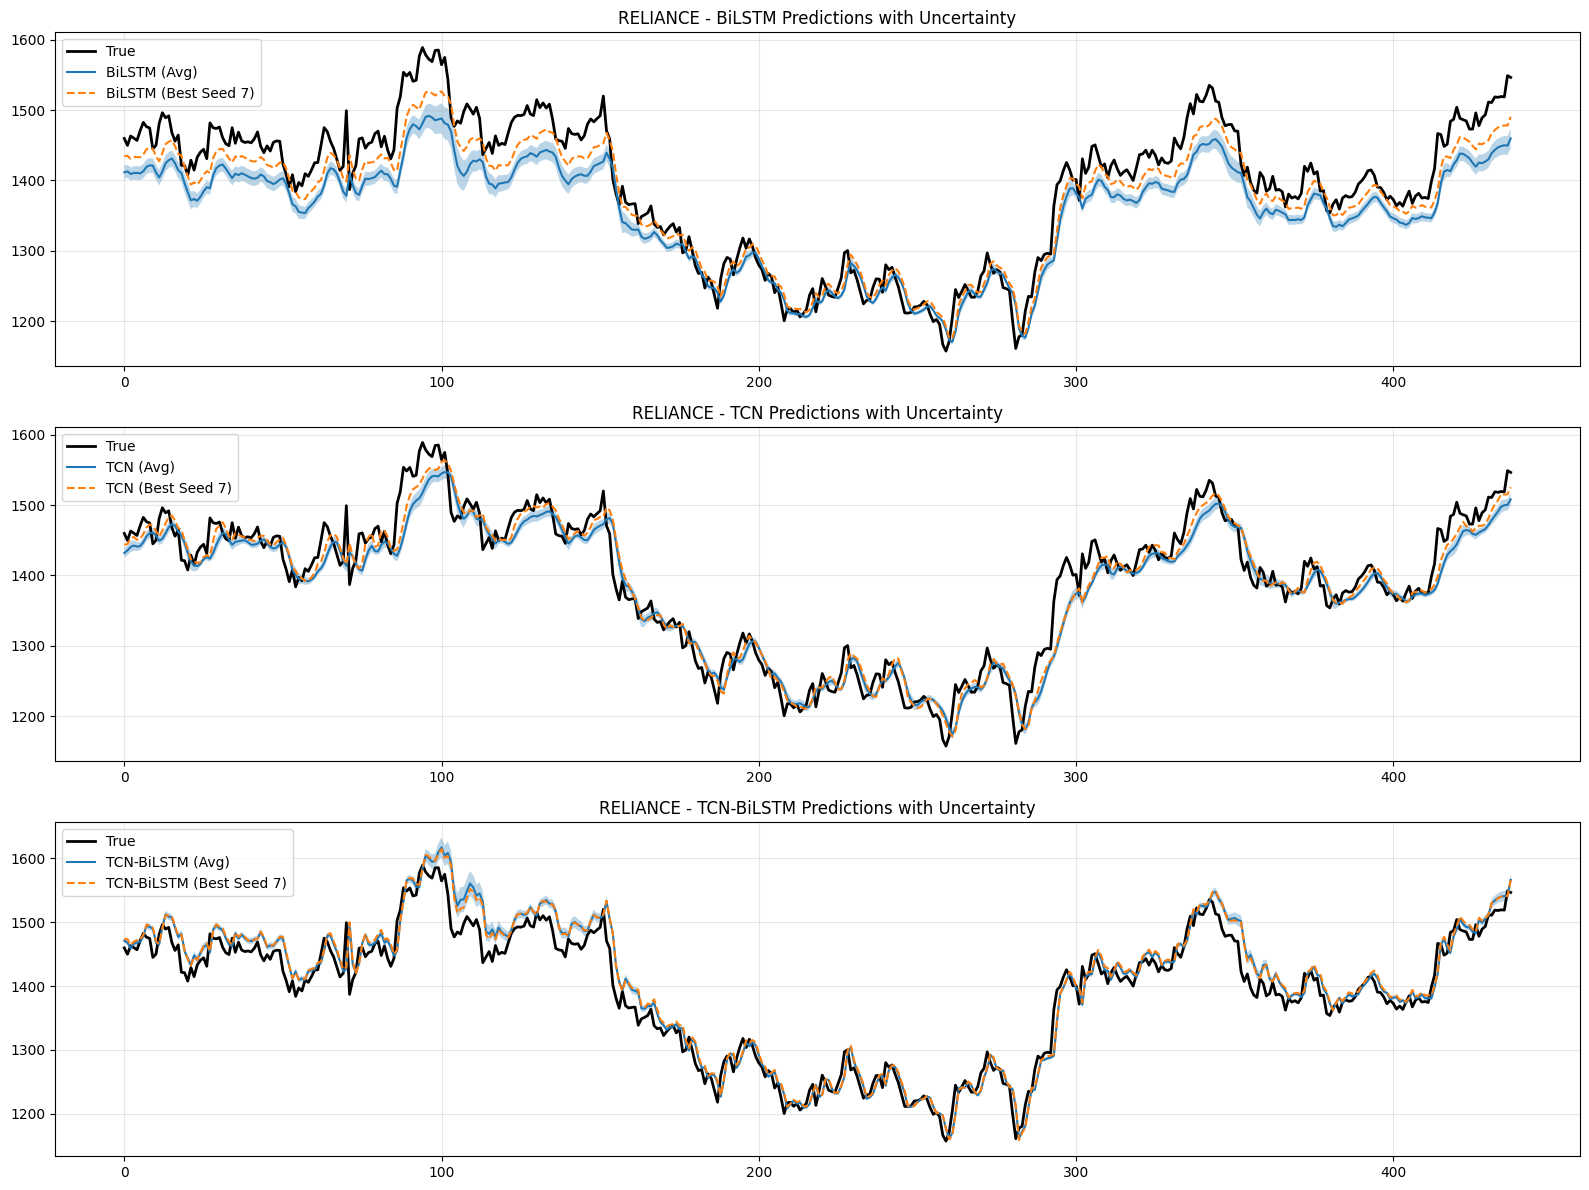


✓ Done!
All DATA saved in:      /content/drive/MyDrive/stock_prediction/data/
All PREDICTIONS saved in:/content/drive/MyDrive/stock_prediction/prediction/
All MODELS saved in:     /content/drive/MyDrive/stock_prediction/saved_models/
Averaged predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>_predictions_avg.csv
Best seed predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>predictions_best_seed<N>.csv
Best seed models saved in: /content/drive/MyDrive/stock_prediction/saved_models/<stock>/<model>best_seed<N>/
Comparison plots saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/comparison_plot.png


In [ ]:
# ----------------------------
# Main Execution
# ----------------------------
if __name__ == "__main__":
    STOCKS = ["reliance"]
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    EPOCHS = 200
    N_SEEDS = 10

    for stock in STOCKS:
        try:
            avg, best = train_nse_multiseed(stock, WINDOW_SIZE, BATCH_SIZE, EPOCHS, N_SEEDS)
            plot_comparison(avg, best, stock)
        except Exception as e:
            print(f"\nFailed to process {stock}: {e}")
            print("Continuing...\n")

    print("\n✓ Done!")
    print(f"All DATA saved in:      {DATA_DRIVE_PATH}")
    print(f"All PREDICTIONS saved in:{PRED_DRIVE_PATH}")
    print(f"All MODELS saved in:     {MODEL_DRIVE_PATH}")
    print(f"Averaged predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>_predictions_avg.csv")
    print(f"Best seed predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>predictions_best_seed<N>.csv")
    print(f"Best seed models saved in: {MODEL_DRIVE_PATH}<stock>/<model>best_seed<N>/")
    print(f"Comparison plots saved in: {PRED_DRIVE_PATH}<stock>/comparison_plot.png")




Training models for TCS with 10 seeds

Fetching TCS.NS from yfinance 2014-01-01 → 2025-11-22
Saved price to /content/drive/MyDrive/stock_prediction/data/tcs/price_data_tcs.csv

------------------------------------------------------------
Training seed 1/10 (seed=0)
------------------------------------------------------------
Seed 0 - Average RMSE: 128.30

------------------------------------------------------------
Training seed 2/10 (seed=1)
------------------------------------------------------------
Seed 1 - Average RMSE: 113.99

------------------------------------------------------------
Training seed 3/10 (seed=2)
------------------------------------------------------------
Seed 2 - Average RMSE: 91.91

------------------------------------------------------------
Training seed 4/10 (seed=3)
------------------------------------------------------------
Seed 3 - Average RMSE: 97.78

------------------------------------------------------------
Training seed 5/10 (seed=4)
-----------

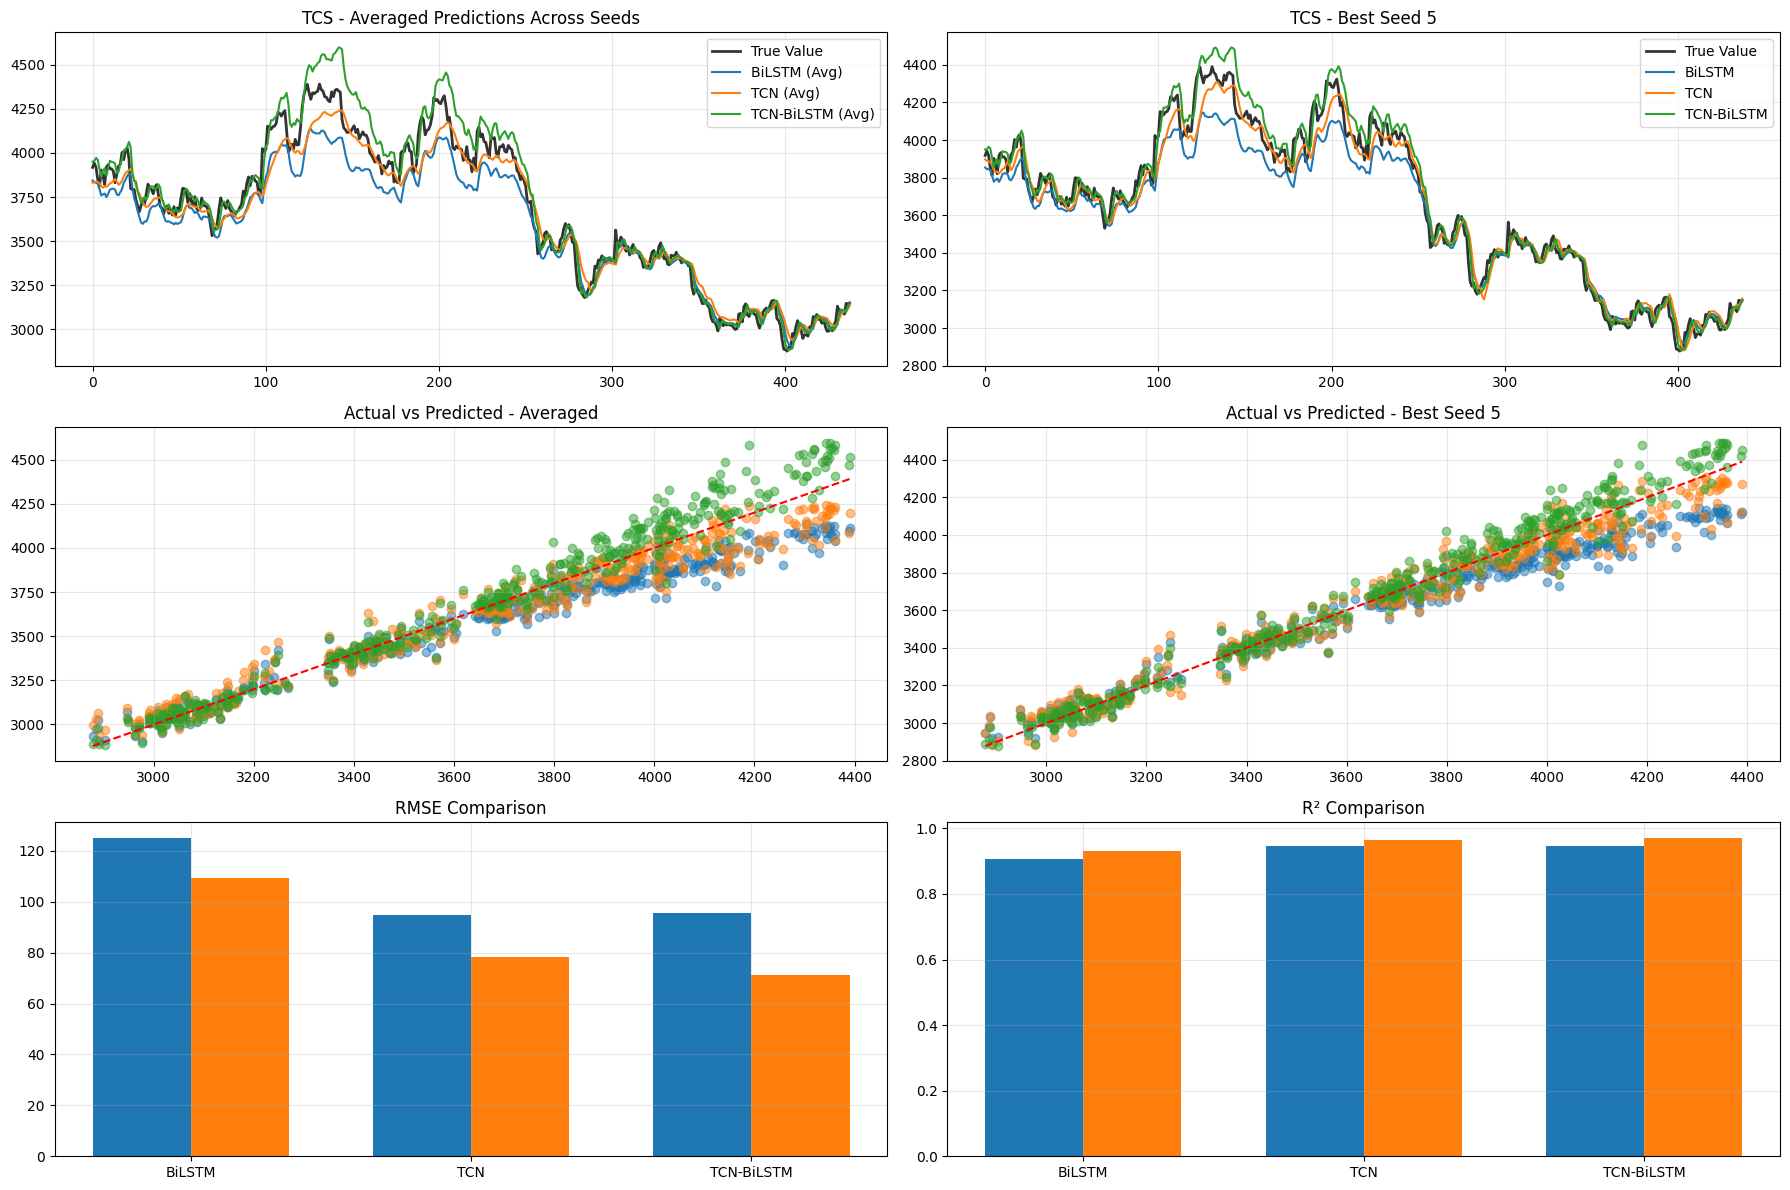

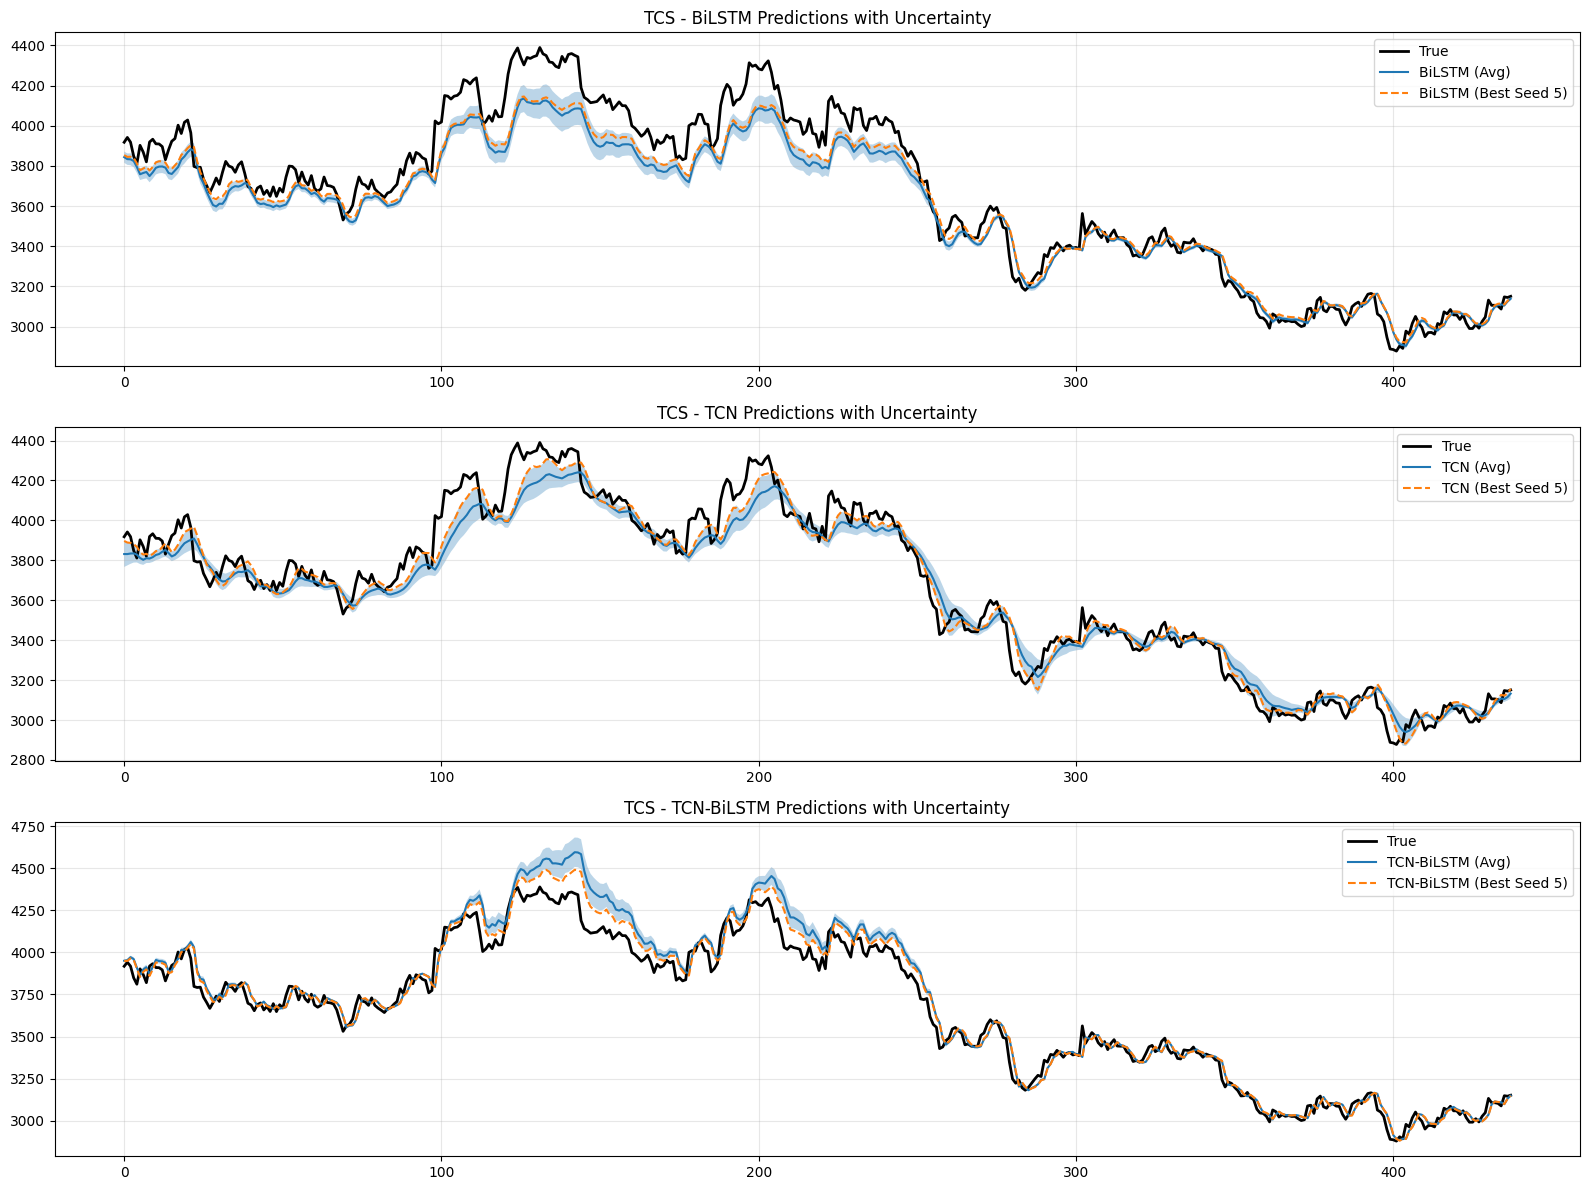


✓ Done!
All DATA saved in:      /content/drive/MyDrive/stock_prediction/data/
All PREDICTIONS saved in:/content/drive/MyDrive/stock_prediction/prediction/
All MODELS saved in:     /content/drive/MyDrive/stock_prediction/saved_models/
Averaged predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>_predictions_avg.csv
Best seed predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>predictions_best_seed<N>.csv
Best seed models saved in: /content/drive/MyDrive/stock_prediction/saved_models/<stock>/<model>best_seed<N>/
Comparison plots saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/comparison_plot.png


In [ ]:
# ----------------------------
# Main Execution
# ----------------------------
if __name__ == "__main__":
    STOCKS = ["tcs"]
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    EPOCHS = 200
    N_SEEDS = 10

    for stock in STOCKS:
        try:
            avg, best = train_nse_multiseed(stock, WINDOW_SIZE, BATCH_SIZE, EPOCHS, N_SEEDS)
            plot_comparison(avg, best, stock)
        except Exception as e:
            print(f"\nFailed to process {stock}: {e}")
            print("Continuing...\n")

    print("\n✓ Done!")
    print(f"All DATA saved in:      {DATA_DRIVE_PATH}")
    print(f"All PREDICTIONS saved in:{PRED_DRIVE_PATH}")
    print(f"All MODELS saved in:     {MODEL_DRIVE_PATH}")
    print(f"Averaged predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>_predictions_avg.csv")
    print(f"Best seed predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>predictions_best_seed<N>.csv")
    print(f"Best seed models saved in: {MODEL_DRIVE_PATH}<stock>/<model>best_seed<N>/")
    print(f"Comparison plots saved in: {PRED_DRIVE_PATH}<stock>/comparison_plot.png")




Training models for HDFC with 10 seeds

Fetching HDFCBANK.NS from yfinance 2014-01-01 → 2025-11-22
Saved price to /content/drive/MyDrive/stock_prediction/data/hdfc/price_data_hdfc.csv

------------------------------------------------------------
Training seed 1/10 (seed=0)
------------------------------------------------------------
Seed 0 - Average RMSE: 23.80

------------------------------------------------------------
Training seed 2/10 (seed=1)
------------------------------------------------------------
Seed 1 - Average RMSE: 33.11

------------------------------------------------------------
Training seed 3/10 (seed=2)
------------------------------------------------------------
Seed 2 - Average RMSE: 24.83

------------------------------------------------------------
Training seed 4/10 (seed=3)
------------------------------------------------------------
Seed 3 - Average RMSE: 28.43

------------------------------------------------------------
Training seed 5/10 (seed=4)
-----

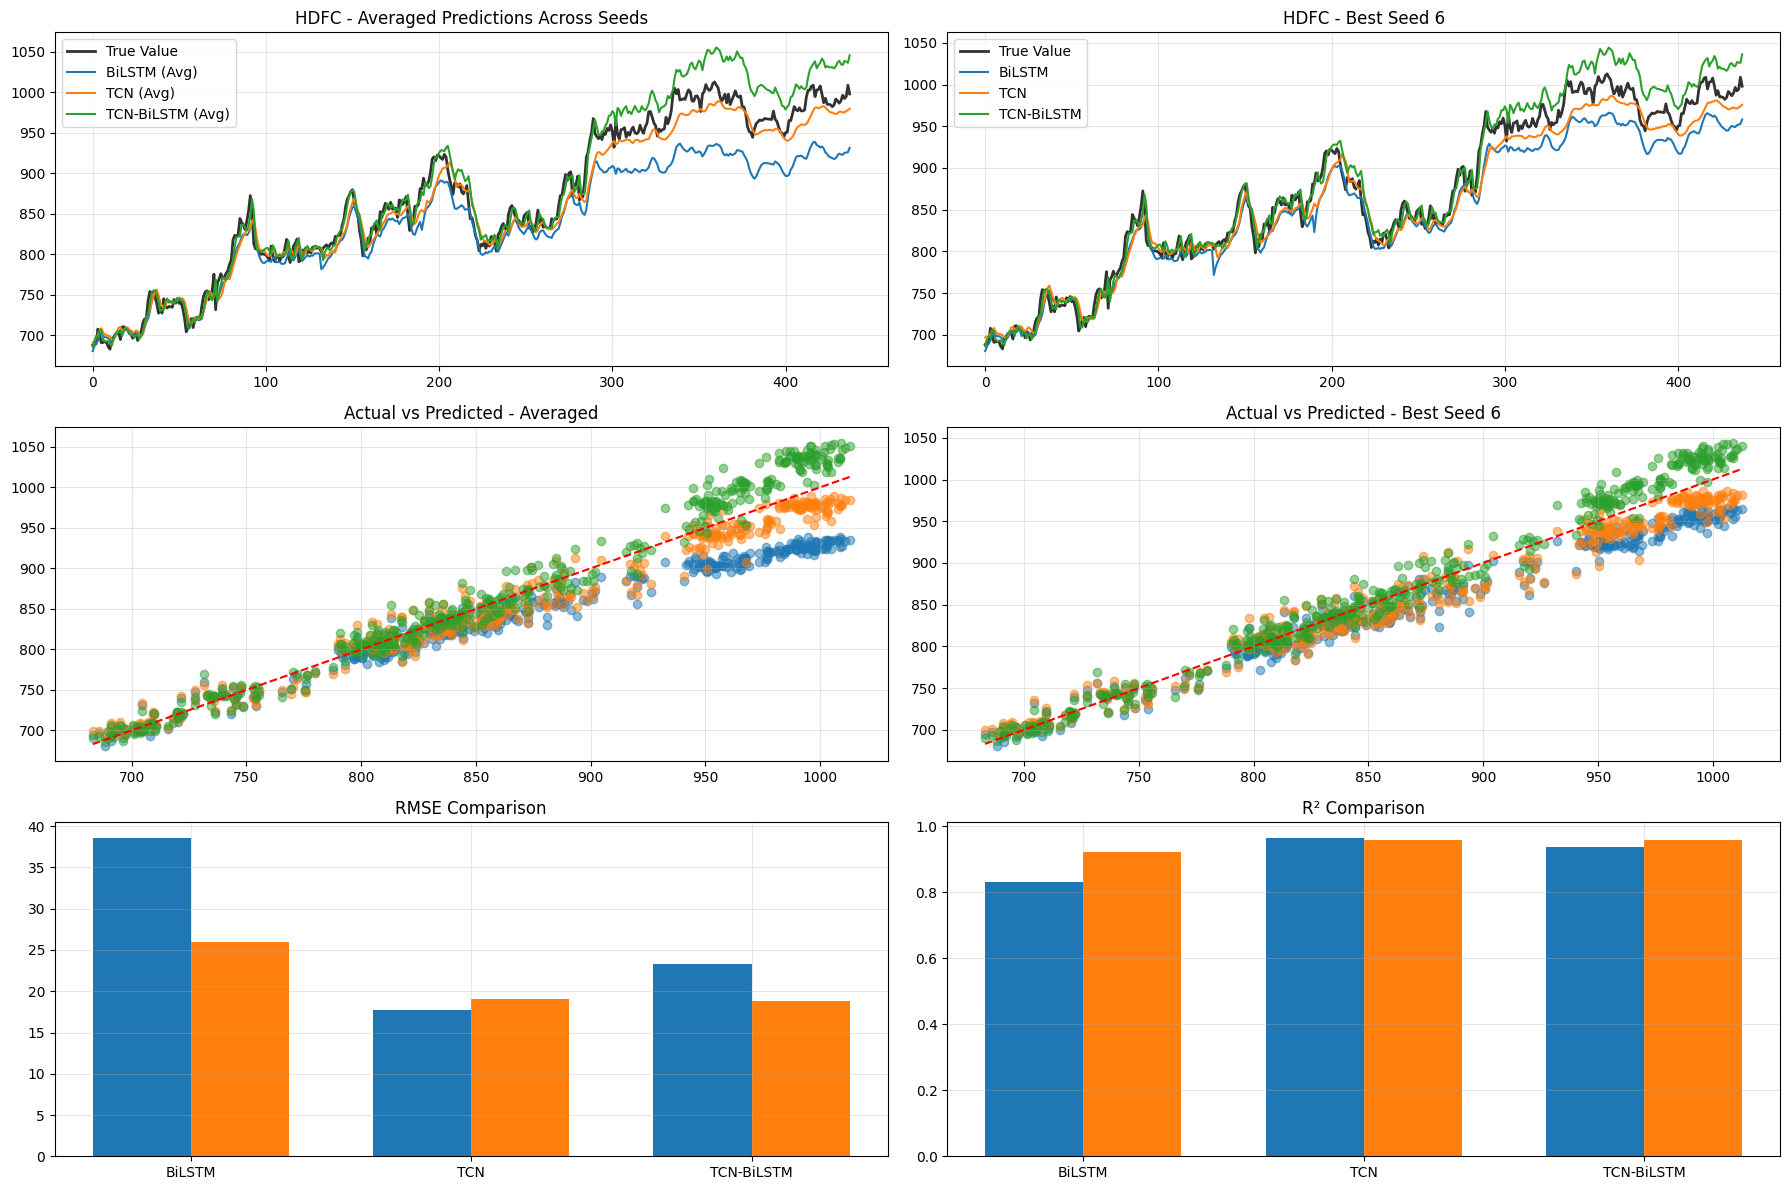

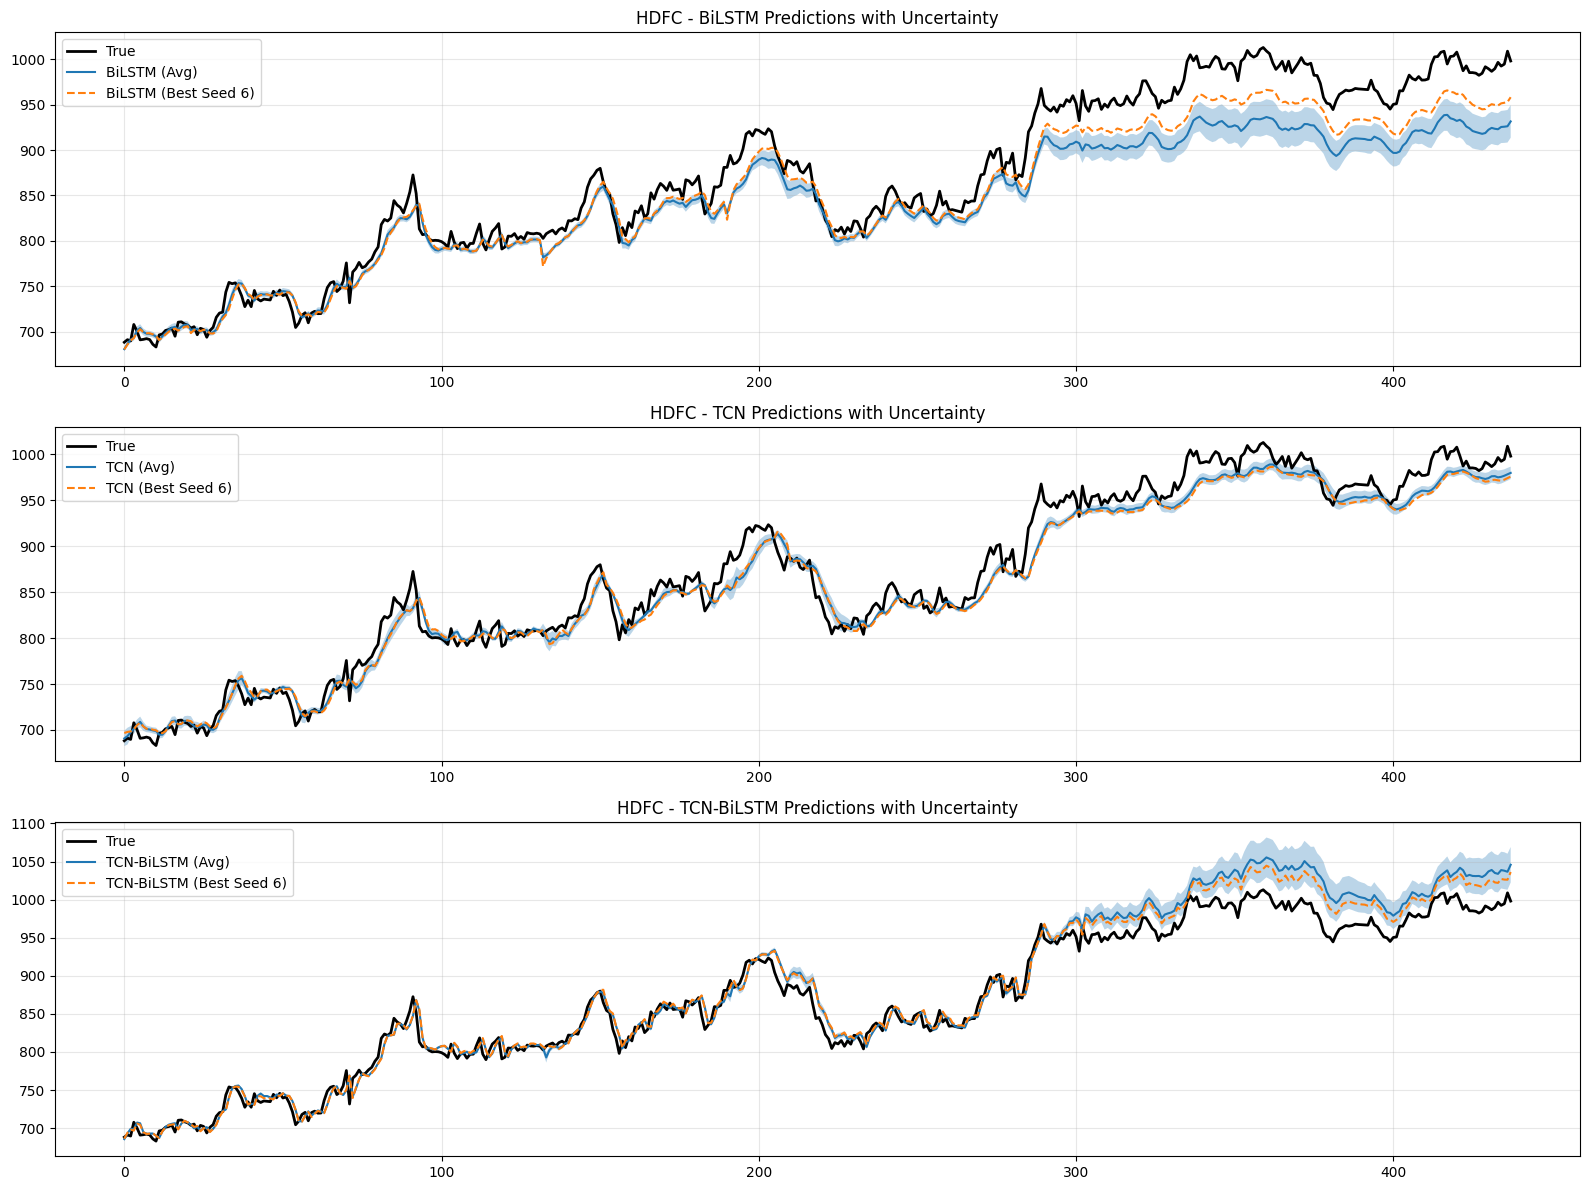


✓ Done!
All DATA saved in:      /content/drive/MyDrive/stock_prediction/data/
All PREDICTIONS saved in:/content/drive/MyDrive/stock_prediction/prediction/
All MODELS saved in:     /content/drive/MyDrive/stock_prediction/saved_models/
Averaged predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>_predictions_avg.csv
Best seed predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>predictions_best_seed<N>.csv
Best seed models saved in: /content/drive/MyDrive/stock_prediction/saved_models/<stock>/<model>best_seed<N>/
Comparison plots saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/comparison_plot.png


In [11]:
# ----------------------------
# Main Execution
# ----------------------------
if __name__ == "__main__":
    STOCKS = ["hdfc"]
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    EPOCHS = 200
    N_SEEDS = 10

    for stock in STOCKS:
        try:
            avg, best = train_nse_multiseed(stock, WINDOW_SIZE, BATCH_SIZE, EPOCHS, N_SEEDS)
            plot_comparison(avg, best, stock)
        except Exception as e:
            print(f"\nFailed to process {stock}: {e}")
            print("Continuing...\n")

    print("\n✓ Done!")
    print(f"All DATA saved in:      {DATA_DRIVE_PATH}")
    print(f"All PREDICTIONS saved in:{PRED_DRIVE_PATH}")
    print(f"All MODELS saved in:     {MODEL_DRIVE_PATH}")
    print(f"Averaged predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>_predictions_avg.csv")
    print(f"Best seed predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>predictions_best_seed<N>.csv")
    print(f"Best seed models saved in: {MODEL_DRIVE_PATH}<stock>/<model>best_seed<N>/")
    print(f"Comparison plots saved in: {PRED_DRIVE_PATH}<stock>/comparison_plot.png")




Training models for INFOSYS with 10 seeds

Fetching INFY.NS from yfinance 2014-01-01 → 2025-11-22
Saved price to /content/drive/MyDrive/stock_prediction/data/infosys/price_data_infosys.csv

------------------------------------------------------------
Training seed 1/10 (seed=0)
------------------------------------------------------------
Seed 0 - Average RMSE: 50.72

------------------------------------------------------------
Training seed 2/10 (seed=1)
------------------------------------------------------------
Seed 1 - Average RMSE: 46.73

------------------------------------------------------------
Training seed 3/10 (seed=2)
------------------------------------------------------------
Seed 2 - Average RMSE: 44.95

------------------------------------------------------------
Training seed 4/10 (seed=3)
------------------------------------------------------------
Seed 3 - Average RMSE: 49.28

------------------------------------------------------------
Training seed 5/10 (seed=4)


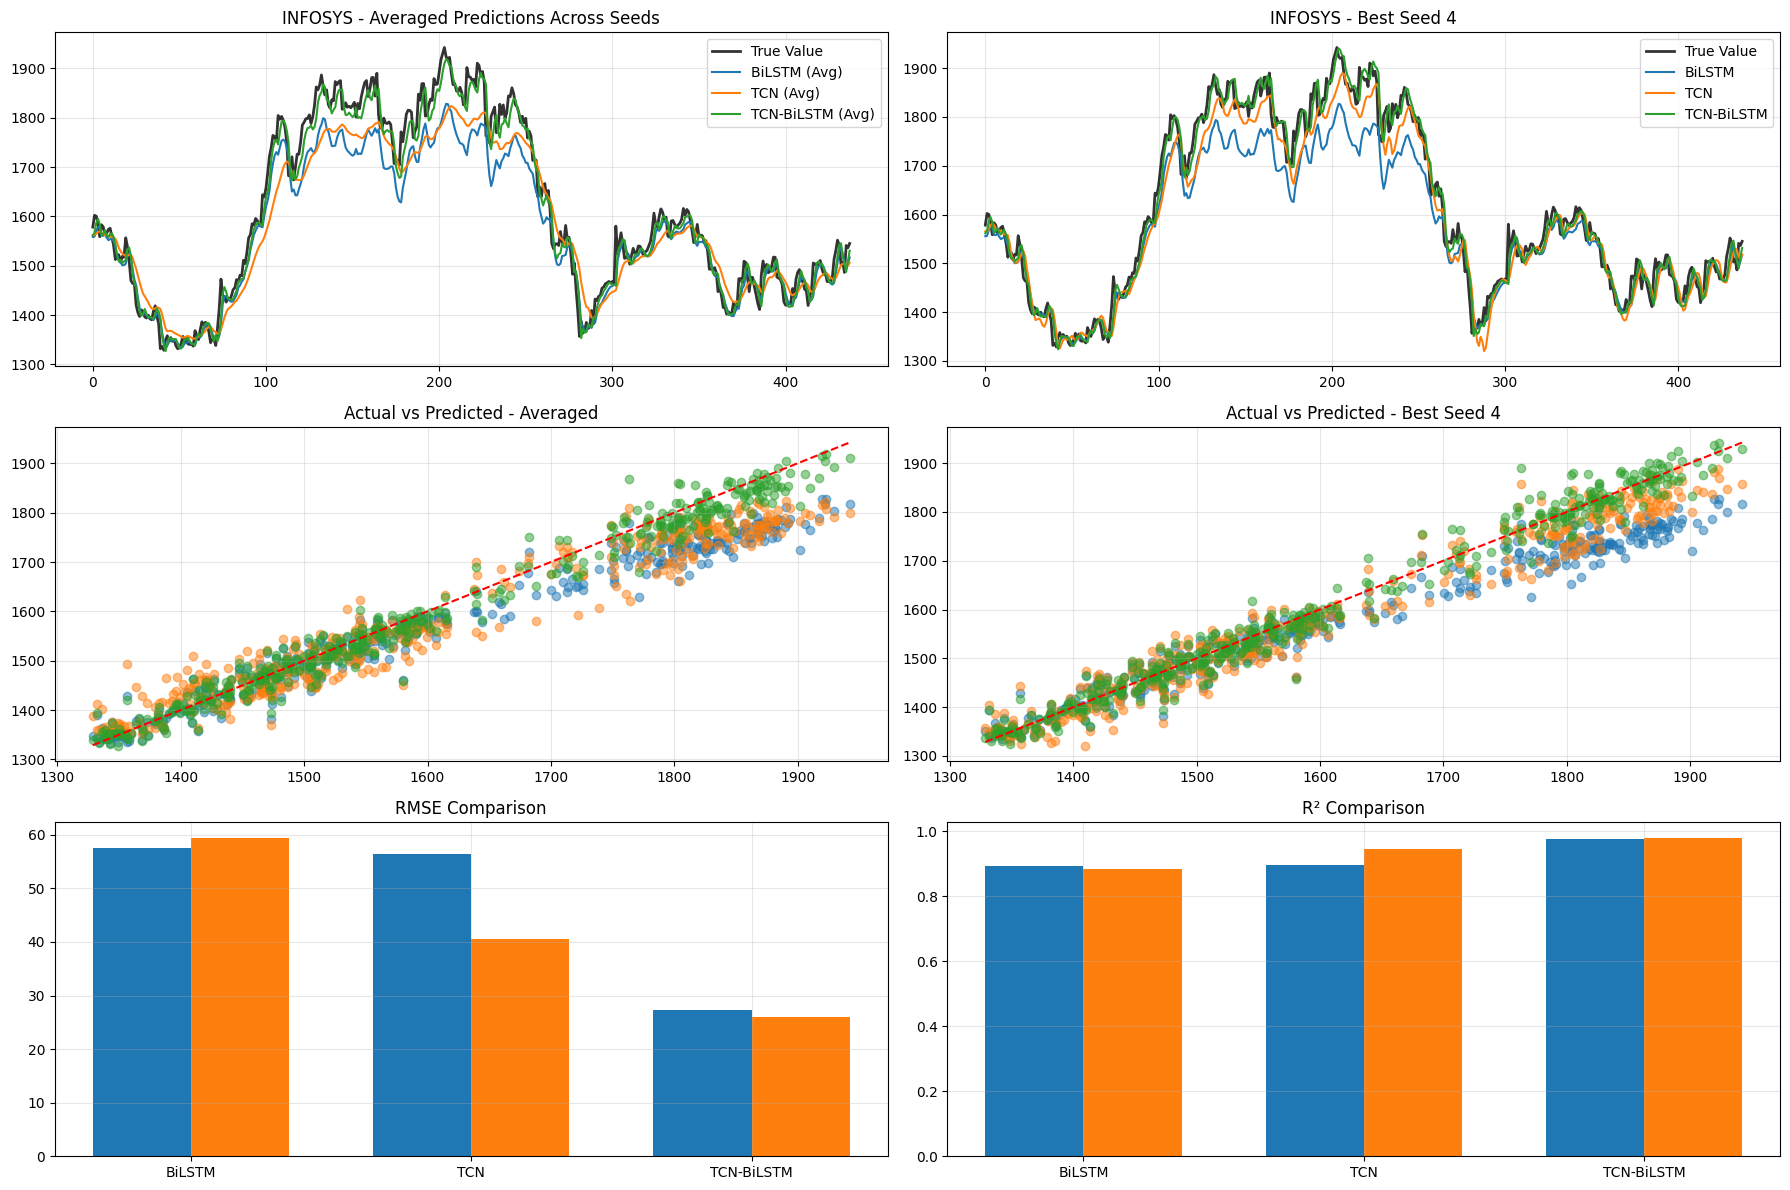

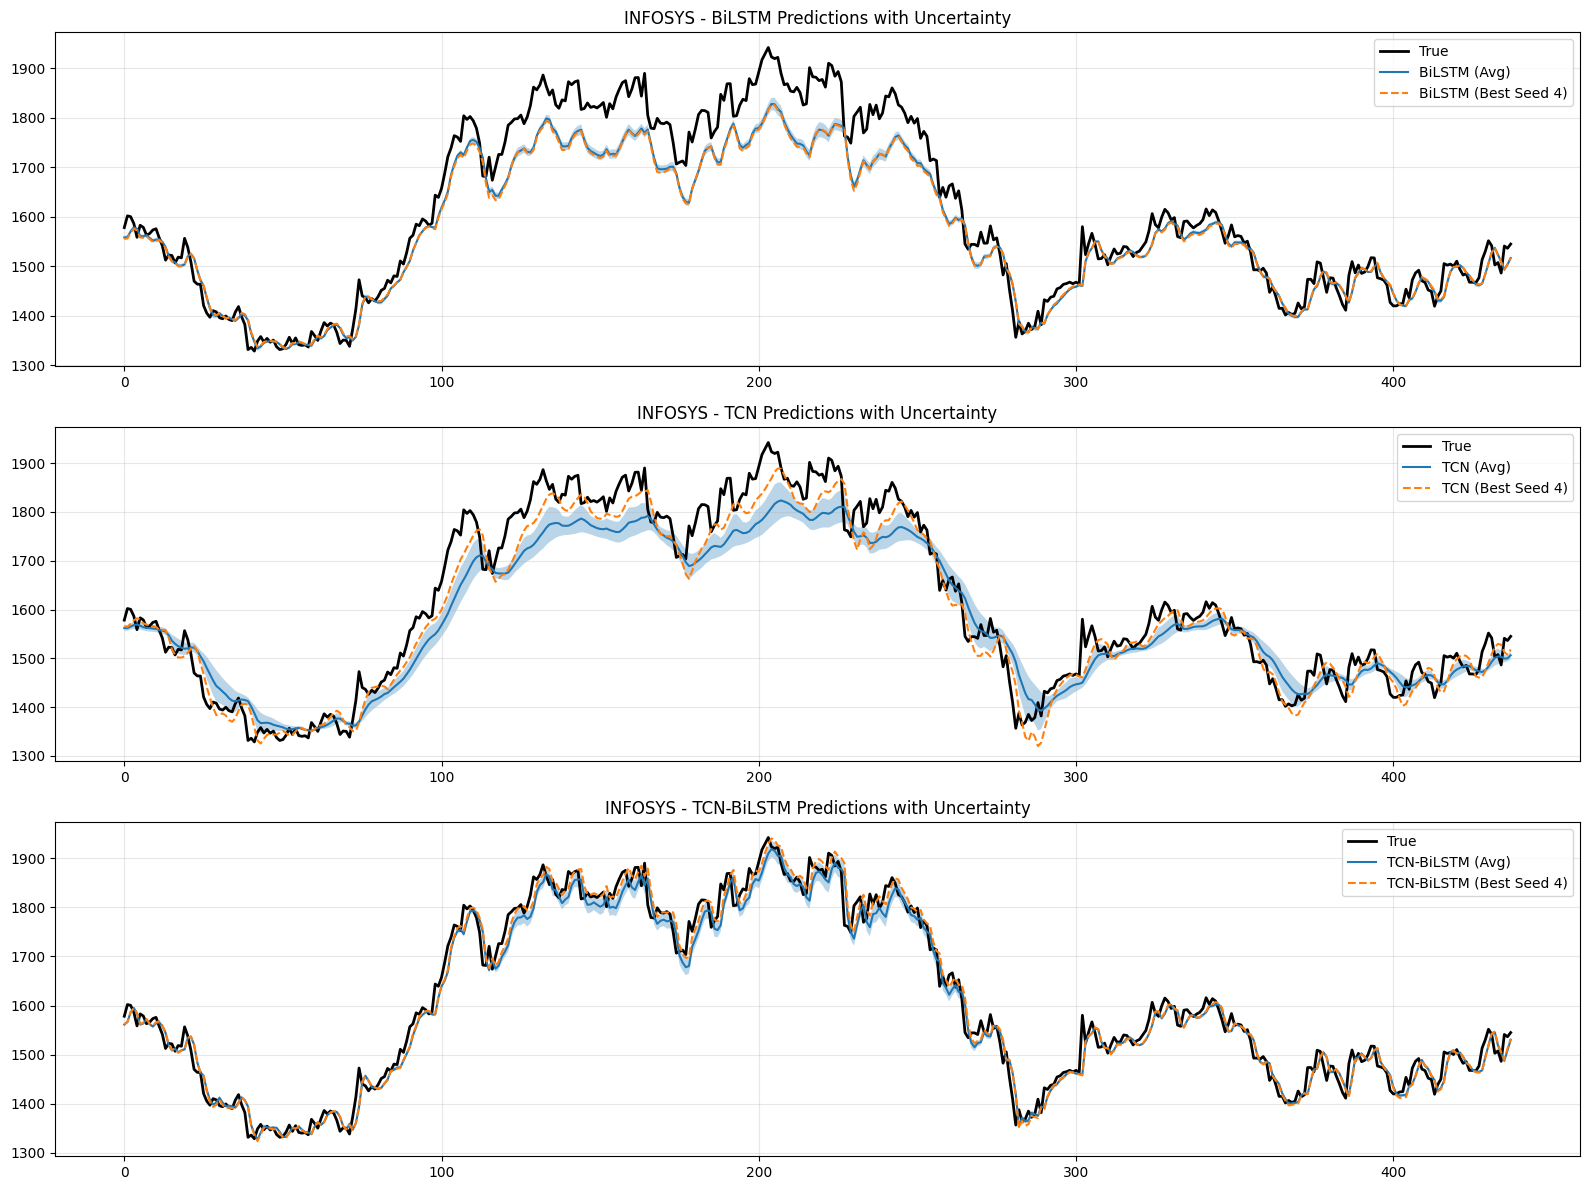


✓ Done!
All DATA saved in:      /content/drive/MyDrive/stock_prediction/data/
All PREDICTIONS saved in:/content/drive/MyDrive/stock_prediction/prediction/
All MODELS saved in:     /content/drive/MyDrive/stock_prediction/saved_models/
Averaged predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>_predictions_avg.csv
Best seed predictions saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/<model>predictions_best_seed<N>.csv
Best seed models saved in: /content/drive/MyDrive/stock_prediction/saved_models/<stock>/<model>best_seed<N>/
Comparison plots saved in: /content/drive/MyDrive/stock_prediction/prediction/<stock>/comparison_plot.png


In [12]:
# ----------------------------
# Main Execution
# ----------------------------
if __name__ == "__main__":
    STOCKS = ["infosys"]
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    EPOCHS = 200
    N_SEEDS = 10

    for stock in STOCKS:
        try:
            avg, best = train_nse_multiseed(stock, WINDOW_SIZE, BATCH_SIZE, EPOCHS, N_SEEDS)
            plot_comparison(avg, best, stock)
        except Exception as e:
            print(f"\nFailed to process {stock}: {e}")
            print("Continuing...\n")

    print("\n✓ Done!")
    print(f"All DATA saved in:      {DATA_DRIVE_PATH}")
    print(f"All PREDICTIONS saved in:{PRED_DRIVE_PATH}")
    print(f"All MODELS saved in:     {MODEL_DRIVE_PATH}")
    print(f"Averaged predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>_predictions_avg.csv")
    print(f"Best seed predictions saved in: {PRED_DRIVE_PATH}<stock>/<model>predictions_best_seed<N>.csv")
    print(f"Best seed models saved in: {MODEL_DRIVE_PATH}<stock>/<model>best_seed<N>/")
    print(f"Comparison plots saved in: {PRED_DRIVE_PATH}<stock>/comparison_plot.png")

